# 1. Define binning and model

In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm
import pyhf
import cabinetry
import json
import yaml
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

## Create templates

In [2]:
cabinetry.set_logging()

In [89]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.4
end = 5
num_bins = 60

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -5
end = 10
num_bins = 60

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)


# Check for empty bins
# empty_bins = [41, 42, 43, 44, 46, 47, 48, 49]

# Merge adjacent empty bins
# merged_bins = np.delete(bins, empty_bins)

# Define relevant variables
training_variables = util.training_variables

In [4]:
## Loading Ntuples
columns = util.all_relevant_variables + ['B0_CMS4_weMissM2']

# Load template samples
e_temp = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/MC15ri_local_200fb/*.root:B0'],
                          library="np",
                          #cut=input_cut,
                          filter_branch=lambda branch: branch.name in columns)

df_e = pd.DataFrame(e_temp)
df_e['__weight__'] = 5

df_e.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
df_e.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

# mu_temp = uproot.concatenate([f'../Samples/Generic_MC15ri/mu_channel/MC15ri_local_200fb/*.root:B0'],
#                           library="np",
#                           #cut=input_cut,
#                           filter_branch=lambda branch: branch.name in columns)

# df_mu = pd.DataFrame(mu_temp)
# df_mu['__weight__'] = 5

# df_mu.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
# df_mu.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [5]:
# load MVA
import lightgbm as lgb
bst_lgb = lgb.Booster(model_file=f'../BDTs/LightGBM/lgbm_multiclass.txt')
cut='signal_prob==largest_prob and signal_prob>0.8 and \
continuum_prob<0.04 and fakeD_prob<0.05'
# e channel
pred_e = bst_lgb.predict(df_e[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out_e = pd.DataFrame(pred_e, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb_e = pd.concat([df_e, lgb_out_e], axis=1)
df_lgb_e['largest_prob'] = df_lgb_e[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred_e, lgb_out_e

df_cut_e=df_lgb_e.query(cut)
df_bestSelected_e=df_cut_e.loc[df_cut_e.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
# mu channel
# pred_mu = bst_lgb.predict(df_mu[training_variables], num_iteration=50) #bst_lgb.best_iteration
# lgb_out_mu = pd.DataFrame(pred_mu, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

# df_lgb_mu = pd.concat([df_mu, lgb_out_mu], axis=1)
# df_lgb_mu['largest_prob'] = df_lgb_mu[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
# del pred_mu, lgb_out_mu

# df_cut_mu=df_lgb_mu.query(cut)
# df_bestSelected_mu=df_cut_mu.loc[df_cut_mu.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]

In [6]:
te=util.get_dataframe_samples_new(df_bestSelected_e, 'e', template=False)
# tmu=util.get_dataframe_samples_new(df_bestSelected_mu, 'mu', template=False)

for name, df in te.items():
    print(name, len(df))
print()
# for name, df in tmu.items():
#     print(name, len(df))

bkg_FakeD 78329
bkg_TDFl 2629
bkg_fakeTracks 1814
bkg_continuum 3110
bkg_combinatorial 8185
bkg_singleBbkg 4584
bkg_other_TDTl 0
$D\tau\nu$ 1574
$D^\ast\tau\nu$ 1072
$D\ell\nu$ 22958
$D^\ast\ell\nu$ 18430
$D^{\ast\ast}\tau\nu$ 663
$D^{\ast\ast}\ell\nu$ 11162
$D\ell\nu$_gap 2830
bkg_other_signal 0



In [90]:
## scale luminosity to 1/ab
indices_threshold_e,temp_asimov_e,temp_asimov_merged_e = util.create_templates(
    samples=te, bins=[MM2_bins, p_D_l_bins], scale_lumi=True,
    variables=['B0_CMS3_weMissM2','p_D_l'],
    bin_threshold=1,merge_threshold=10,
    sample_to_exclude=[#'bkg_FakeD','bkg_TDFl','bkg_continuum','bkg_combinatorial','bkg_singleBbkg',
                       'bkg_fakeTracks','bkg_other_TDTl','bkg_other_signal'])
# (template_flat_e,staterr_flat_e,asimov_data_e) = temp_asimov_e
# (template_flat_e_merged,staterr_flat_e_merged,asimov_data_e_merged) = temp_asimov_merged_e

# indices_threshold_mu,temp_asimov_mu,temp_asimov_merged_mu = util.create_templates(
#     samples=tmu, bins=[MM2_bins, p_D_l_bins], scale_lumi=True,
#     variables=['B0_CMS3_weMissM2','p_D_l'],
#     bin_threshold=1,merge_threshold=10,
#     sample_to_exclude=[#'bkg_FakeD','bkg_TDFl','bkg_continuum','bkg_combinatorial','bkg_singleBbkg',
#                        'bkg_fakeTracks','bkg_other_TDTl','bkg_other_signal'])

original template length = 1136
new template length = 1070


# 2. Create a pyhf workspace

In [8]:
workspace_path = '2d_ws_SR_1ch.json'
spec = cabinetry.workspace.load(workspace_path)
print(json.dumps(spec, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "electron",
            "samples": [
                {
                    "data": [
                        2.0,
                        1.0,
                        5.0,
                        4.0,
                        2.0,
                        1.0,
                        4.0,
                        2.0,
                        10.0,
                        16.0,
                        15.0,
                        20.0,
                        20.0,
                        9.0,
                        4.0,
                        0.0,
                        4.0,
                        5.0,
                        5.0,
                        12.0,
                        17.0,
                        30.0,
                        38.0,
                        40.0,
                        45.0,
                        27.0,
                        13.0,
                        8.0,
                        0.0,
           

In [91]:
# update templates and data in the workspace
# signal region
spec_e = util.update_workspace(workspace=spec,
                             temp_asimov_sets=[temp_asimov_e],
                             staterror=True)

print(json.dumps(spec_e, sort_keys=True, indent=4))

# cabinetry.workspace.save(spec_e, '../Toys_pipeline/2d_ws_SR_e_60_60_1ab.json')

{
    "channels": [
        {
            "name": "electron",
            "samples": [
                {
                    "data": [
                        10.0,
                        15.0,
                        30.0,
                        25.0,
                        45.0,
                        20.0,
                        15.0,
                        40.0,
                        55.0,
                        105.0,
                        95.0,
                        75.0,
                        35.0,
                        10.0,
                        40.0,
                        45.0,
                        135.0,
                        160.0,
                        120.0,
                        220.0,
                        150.0,
                        85.0,
                        10.0,
                        10.0,
                        10.0,
                        25.0,
                        140.0,
                        255.0,
                 

In [10]:
spec_mu = util.update_workspace(workspace=spec,
                             temp_asimov_sets=[temp_asimov_mu],
                             staterror=True)

print(json.dumps(spec_mu, sort_keys=True, indent=4))

# cabinetry.workspace.save(spec_mu, '../Toys_pipeline/2d_ws_SR_mu_60_60_1ab.json')

DEBUG - cabinetry.workspace - saving workspace to ../Toys_pipeline/2d_ws_SR_mu_60_60_1ab.json


{
    "channels": [
        {
            "name": "electron",
            "samples": [
                {
                    "data": [
                        5.0,
                        15.0,
                        5.0,
                        5.0,
                        15.0,
                        15.0,
                        30.0,
                        20.0,
                        30.0,
                        5.0,
                        5.0,
                        5.0,
                        15.0,
                        20.0,
                        25.0,
                        55.0,
                        65.0,
                        40.0,
                        40.0,
                        10.0,
                        5.0,
                        10.0,
                        30.0,
                        30.0,
                        60.0,
                        95.0,
                        155.0,
                        95.0,
                        90.0,
 

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_FakeD_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_

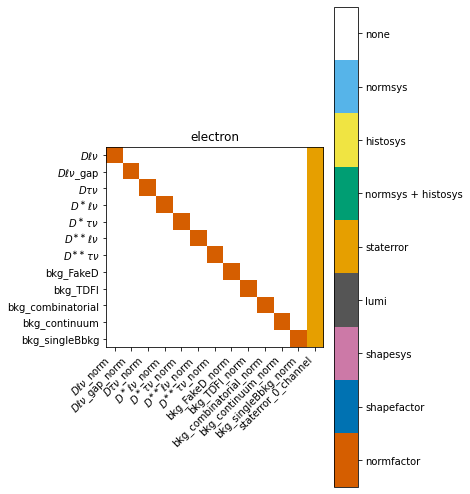

In [92]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec).model())

In [93]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_FakeD_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_

In [94]:
toy_pars = model.config.suggested_init()
toy_pars[:12] = [0.4]*12
# rng = np.random.default_rng(0)
# toy_pars[:8] = list(rng.uniform(0.01,0.2,8))
# minos_parameters = model.config.parameters[:8]
# minos_parameters.remove('bkg_fakeD_norm')
        
# generate the toys:
pdf_toy = model.make_pdf(pyhf.tensorlib.astensor(toy_pars))
toys = pdf_toy.sample((2,))
fix_par = [False,False,False,False,False,False,False,True,True,True,True,True]

In [28]:
pyhf.set_backend('jax', 'scipy')
init_pars = pyhf.infer.mle.fit(data=toys[0], pdf=model,
                               init_pars=toy_pars,
#                                fixed_params=fix_par,
                              ).tolist()
init_pars[:12]

[0.3968556404370528,
 0.22546196659910708,
 0.5693093405880565,
 0.4078478534403695,
 0.33010009442262217,
 0.41475612239148496,
 0.37413139100963827,
 0.39385805663805423,
 0.5345517522753822,
 0.3846769184849251,
 0.3977144211173874,
 0.44536120540592294]

In [95]:
pyhf.set_backend('jax', 'minuit')
res = cabinetry.fit.fit(
    model,
    data=toys[0],
    init_pars=toy_pars,
    #fix_pars = fix_par,
    # par_bounds=par_bounds,
    goodness_of_fit=True,
#     minos=minos_parameters
)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4250                       │      Nfcn = 667292, Ngrad = 18       │
│ EDM = 0.000351 (Goal: 0.0002)    │          time = 1368.2 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

INFO - cabinetry.fit - staterror_0_channel[88]    =  0.9580 +/- 0.0417
INFO - cabinetry.fit - staterror_0_channel[89]    =  0.9138 +/- 0.0308
INFO - cabinetry.fit - staterror_0_channel[90]    =  1.0007 +/- 0.0306
INFO - cabinetry.fit - staterror_0_channel[91]    =  1.0546 +/- 0.0268
INFO - cabinetry.fit - staterror_0_channel[92]    =  0.9785 +/- 0.0254
INFO - cabinetry.fit - staterror_0_channel[93]    =  1.0203 +/- 0.0230
INFO - cabinetry.fit - staterror_0_channel[94]    =  0.9701 +/- 0.0238
INFO - cabinetry.fit - staterror_0_channel[95]    =  0.9999 +/- 0.0290
INFO - cabinetry.fit - staterror_0_channel[96]    =  0.9649 +/- 0.0386
INFO - cabinetry.fit - staterror_0_channel[97]    =  0.9801 +/- 0.0536
INFO - cabinetry.fit - staterror_0_channel[98]    =  1.0662 +/- 0.1742
INFO - cabinetry.fit - staterror_0_channel[99]    =  0.8985 +/- 0.3991
INFO - cabinetry.fit - staterror_0_channel[100]   =  0.9511 +/- 0.2535
INFO - cabinetry.fit - staterror_0_channel[101]   =  0.8266 +/- 0.1180
INFO -

INFO - cabinetry.fit - staterror_0_channel[204]   =  0.9778 +/- 0.0885
INFO - cabinetry.fit - staterror_0_channel[205]   =  0.9240 +/- 0.0657
INFO - cabinetry.fit - staterror_0_channel[206]   =  1.0307 +/- 0.0505
INFO - cabinetry.fit - staterror_0_channel[207]   =  0.9807 +/- 0.0493
INFO - cabinetry.fit - staterror_0_channel[208]   =  1.0314 +/- 0.0418
INFO - cabinetry.fit - staterror_0_channel[209]   =  0.9953 +/- 0.0378
INFO - cabinetry.fit - staterror_0_channel[210]   =  1.0336 +/- 0.0340
INFO - cabinetry.fit - staterror_0_channel[211]   =  1.0486 +/- 0.0292
INFO - cabinetry.fit - staterror_0_channel[212]   =  0.9898 +/- 0.0262
INFO - cabinetry.fit - staterror_0_channel[213]   =  1.0201 +/- 0.0246
INFO - cabinetry.fit - staterror_0_channel[214]   =  0.9930 +/- 0.0196
INFO - cabinetry.fit - staterror_0_channel[215]   =  1.0021 +/- 0.0183
INFO - cabinetry.fit - staterror_0_channel[216]   =  0.9932 +/- 0.0185
INFO - cabinetry.fit - staterror_0_channel[217]   =  1.0179 +/- 0.0175
INFO -

INFO - cabinetry.fit - staterror_0_channel[320]   =  1.0109 +/- 0.0200
INFO - cabinetry.fit - staterror_0_channel[321]   =  0.9656 +/- 0.0248
INFO - cabinetry.fit - staterror_0_channel[322]   =  0.9722 +/- 0.0455
INFO - cabinetry.fit - staterror_0_channel[323]   =  1.0623 +/- 0.1381
INFO - cabinetry.fit - staterror_0_channel[324]   =  1.0567 +/- 0.2081
INFO - cabinetry.fit - staterror_0_channel[325]   =  1.1102 +/- 0.2340
INFO - cabinetry.fit - staterror_0_channel[326]   =  0.9129 +/- 0.1214
INFO - cabinetry.fit - staterror_0_channel[327]   =  0.8586 +/- 0.1104
INFO - cabinetry.fit - staterror_0_channel[328]   =  1.0271 +/- 0.0699
INFO - cabinetry.fit - staterror_0_channel[329]   =  0.9719 +/- 0.0543
INFO - cabinetry.fit - staterror_0_channel[330]   =  1.0591 +/- 0.0536
INFO - cabinetry.fit - staterror_0_channel[331]   =  1.0527 +/- 0.0440
INFO - cabinetry.fit - staterror_0_channel[332]   =  1.0648 +/- 0.0354
INFO - cabinetry.fit - staterror_0_channel[333]   =  0.9899 +/- 0.0379
INFO -

INFO - cabinetry.fit - staterror_0_channel[436]   =  0.7584 +/- 0.4451
INFO - cabinetry.fit - staterror_0_channel[437]   =  0.7473 +/- 0.2122
INFO - cabinetry.fit - staterror_0_channel[438]   =  1.1255 +/- 0.1724
INFO - cabinetry.fit - staterror_0_channel[439]   =  1.1518 +/- 0.1905
INFO - cabinetry.fit - staterror_0_channel[440]   =  1.0699 +/- 0.1232
INFO - cabinetry.fit - staterror_0_channel[441]   =  1.0507 +/- 0.0802
INFO - cabinetry.fit - staterror_0_channel[442]   =  1.0331 +/- 0.0727
INFO - cabinetry.fit - staterror_0_channel[443]   =  0.9581 +/- 0.0539
INFO - cabinetry.fit - staterror_0_channel[444]   =  0.9778 +/- 0.0405
INFO - cabinetry.fit - staterror_0_channel[445]   =  1.0291 +/- 0.0393
INFO - cabinetry.fit - staterror_0_channel[446]   =  0.9866 +/- 0.0340
INFO - cabinetry.fit - staterror_0_channel[447]   =  1.0042 +/- 0.0318
INFO - cabinetry.fit - staterror_0_channel[448]   =  1.0417 +/- 0.0276
INFO - cabinetry.fit - staterror_0_channel[449]   =  0.9927 +/- 0.0248
INFO -

INFO - cabinetry.fit - staterror_0_channel[552]   =  0.8100 +/- 0.1902
INFO - cabinetry.fit - staterror_0_channel[553]   =  0.4703 +/- 0.2662
INFO - cabinetry.fit - staterror_0_channel[554]   =  1.3983 +/- 0.2711
INFO - cabinetry.fit - staterror_0_channel[555]   =  1.4353 +/- 0.2891
INFO - cabinetry.fit - staterror_0_channel[556]   =  1.2909 +/- 0.2984
INFO - cabinetry.fit - staterror_0_channel[557]   =  0.9109 +/- 0.1048
INFO - cabinetry.fit - staterror_0_channel[558]   =  0.9092 +/- 0.1438
INFO - cabinetry.fit - staterror_0_channel[559]   =  0.7253 +/- 0.1142
INFO - cabinetry.fit - staterror_0_channel[560]   =  0.9510 +/- 0.0938
INFO - cabinetry.fit - staterror_0_channel[561]   =  1.0817 +/- 0.0699
INFO - cabinetry.fit - staterror_0_channel[562]   =  0.9683 +/- 0.0697
INFO - cabinetry.fit - staterror_0_channel[563]   =  0.9790 +/- 0.0508
INFO - cabinetry.fit - staterror_0_channel[564]   =  0.9793 +/- 0.0400
INFO - cabinetry.fit - staterror_0_channel[565]   =  0.9444 +/- 0.0336
INFO -

INFO - cabinetry.fit - staterror_0_channel[668]   =  1.0458 +/- 0.0196
INFO - cabinetry.fit - staterror_0_channel[669]   =  0.9342 +/- 0.0198
INFO - cabinetry.fit - staterror_0_channel[670]   =  0.9772 +/- 0.0225
INFO - cabinetry.fit - staterror_0_channel[671]   =  0.9855 +/- 0.0226
INFO - cabinetry.fit - staterror_0_channel[672]   =  1.0105 +/- 0.0259
INFO - cabinetry.fit - staterror_0_channel[673]   =  0.9762 +/- 0.0450
INFO - cabinetry.fit - staterror_0_channel[674]   =  0.9695 +/- 0.1946
INFO - cabinetry.fit - staterror_0_channel[675]   =  1.0686 +/- 0.4113
INFO - cabinetry.fit - staterror_0_channel[676]   =  1.1575 +/- 0.3915
INFO - cabinetry.fit - staterror_0_channel[677]   =  0.8253 +/- 0.3919
INFO - cabinetry.fit - staterror_0_channel[678]   =  1.0794 +/- 0.4120
INFO - cabinetry.fit - staterror_0_channel[679]   =  1.1466 +/- 0.4458
INFO - cabinetry.fit - staterror_0_channel[680]   =  0.6816 +/- 0.1869
INFO - cabinetry.fit - staterror_0_channel[681]   =  0.6134 +/- 0.1365
INFO -

INFO - cabinetry.fit - staterror_0_channel[784]   =  0.9670 +/- 0.0199
INFO - cabinetry.fit - staterror_0_channel[785]   =  0.9824 +/- 0.0180
INFO - cabinetry.fit - staterror_0_channel[786]   =  0.9898 +/- 0.0167
INFO - cabinetry.fit - staterror_0_channel[787]   =  1.0125 +/- 0.0158
INFO - cabinetry.fit - staterror_0_channel[788]   =  1.0214 +/- 0.0172
INFO - cabinetry.fit - staterror_0_channel[789]   =  0.9968 +/- 0.0195
INFO - cabinetry.fit - staterror_0_channel[790]   =  1.0019 +/- 0.0215
INFO - cabinetry.fit - staterror_0_channel[791]   =  1.0258 +/- 0.0245
INFO - cabinetry.fit - staterror_0_channel[792]   =  0.9864 +/- 0.0293
INFO - cabinetry.fit - staterror_0_channel[793]   =  0.9692 +/- 0.0520
INFO - cabinetry.fit - staterror_0_channel[794]   =  1.2179 +/- 0.3769
INFO - cabinetry.fit - staterror_0_channel[795]   =  1.1064 +/- 0.1539
INFO - cabinetry.fit - staterror_0_channel[796]   =  1.3106 +/- 0.2364
INFO - cabinetry.fit - staterror_0_channel[797]   =  0.9722 +/- 0.2218
INFO -

INFO - cabinetry.fit - staterror_0_channel[900]   =  0.9864 +/- 0.0228
INFO - cabinetry.fit - staterror_0_channel[901]   =  0.9494 +/- 0.0282
INFO - cabinetry.fit - staterror_0_channel[902]   =  0.9852 +/- 0.0451
INFO - cabinetry.fit - staterror_0_channel[903]   =  0.8682 +/- 0.2028
INFO - cabinetry.fit - staterror_0_channel[904]   =  1.2637 +/- 0.2239
INFO - cabinetry.fit - staterror_0_channel[905]   =  1.1515 +/- 0.1991
INFO - cabinetry.fit - staterror_0_channel[906]   =  1.3779 +/- 0.2708
INFO - cabinetry.fit - staterror_0_channel[907]   =  0.7877 +/- 0.3883
INFO - cabinetry.fit - staterror_0_channel[908]   =  1.0212 +/- 0.2307
INFO - cabinetry.fit - staterror_0_channel[909]   =  1.0451 +/- 0.2704
INFO - cabinetry.fit - staterror_0_channel[910]   =  1.1029 +/- 0.1803
INFO - cabinetry.fit - staterror_0_channel[911]   =  0.9764 +/- 0.1730
INFO - cabinetry.fit - staterror_0_channel[912]   =  1.2424 +/- 0.1444
INFO - cabinetry.fit - staterror_0_channel[913]   =  1.1057 +/- 0.1656
INFO -

INFO - cabinetry.fit - staterror_0_channel[1016]  =  0.4581 +/- 0.3187
INFO - cabinetry.fit - staterror_0_channel[1017]  =  0.8672 +/- 0.3962
INFO - cabinetry.fit - staterror_0_channel[1018]  =  1.3246 +/- 0.4026
INFO - cabinetry.fit - staterror_0_channel[1019]  =  0.7298 +/- 0.2694
INFO - cabinetry.fit - staterror_0_channel[1020]  =  0.9270 +/- 0.2255
INFO - cabinetry.fit - staterror_0_channel[1021]  =  1.0392 +/- 0.1685
INFO - cabinetry.fit - staterror_0_channel[1022]  =  0.9413 +/- 0.1265
INFO - cabinetry.fit - staterror_0_channel[1023]  =  0.9598 +/- 0.1099
INFO - cabinetry.fit - staterror_0_channel[1024]  =  1.0096 +/- 0.0385
INFO - cabinetry.fit - staterror_0_channel[1025]  =  0.9150 +/- 0.0298
INFO - cabinetry.fit - staterror_0_channel[1026]  =  1.0245 +/- 0.0254
INFO - cabinetry.fit - staterror_0_channel[1027]  =  0.9996 +/- 0.0234
INFO - cabinetry.fit - staterror_0_channel[1028]  =  1.0290 +/- 0.0273
INFO - cabinetry.fit - staterror_0_channel[1029]  =  0.9837 +/- 0.0749
INFO -

INFO - cabinetry.fit - staterror_0_channel[1132]  =  1.1954 +/- 0.4186
INFO - cabinetry.fit - staterror_0_channel[1133]  =  1.2140 +/- 0.1466
INFO - cabinetry.fit - staterror_0_channel[1134]  =  1.1309 +/- 0.3900
INFO - cabinetry.fit - staterror_0_channel[1135]  =  1.0460 +/- 0.3591
INFO - cabinetry.fit - calculating goodness-of-fit
DEBUG - cabinetry.fit - Delta NLL = 578.769393
DEBUG - cabinetry.fit - number of degrees of freedom: 1124
INFO - cabinetry.fit - p-value for goodness-of-fit test: 23.75%


In [96]:
temp_2d, stat_2d,data_2d = util.create_2d_template(
    template_flat=temp_asimov_e[0],
    staterror_flat=temp_asimov_e[1],
    data_flat=toys[0][:1136],
    indices_threshold=indices_threshold_e,
    bins=[MM2_bins, p_D_l_bins])

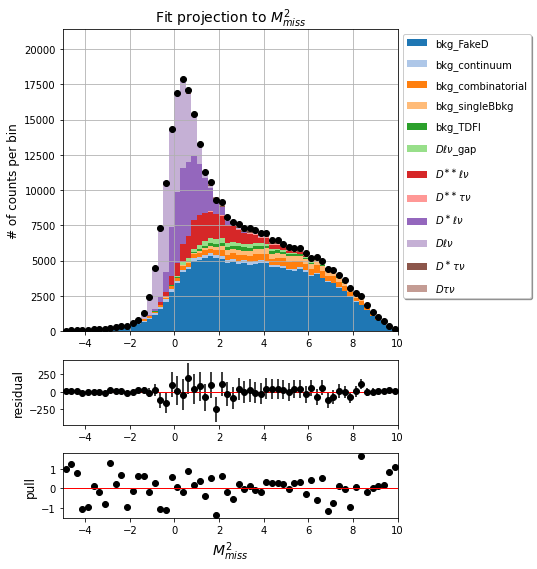

In [97]:
fig = util.fit_project_cabinetry(fit_result=res, templates_2d=temp_2d,
                      staterror_2d=stat_2d,data_2d=data_2d, 
                      edges_list=[MM2_bins, p_D_l_bins], 
                      direction='mm2', slice_thresholds=None)

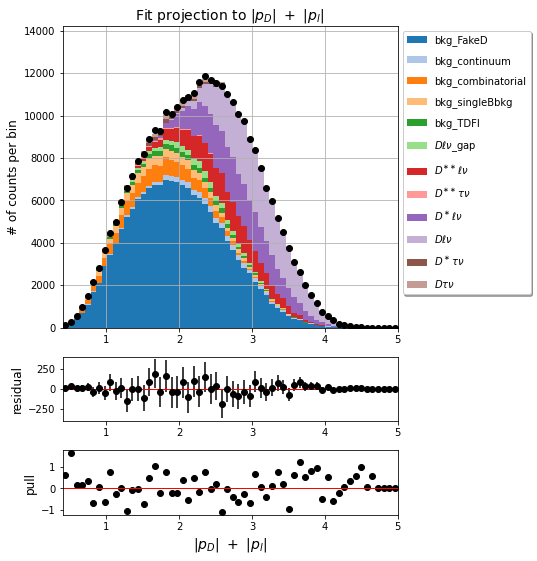

In [98]:
fig = util.fit_project_cabinetry(fit_result=res, templates_2d=temp_2d,
                      staterror_2d=stat_2d,data_2d=data_2d, 
                      edges_list=[MM2_bins, p_D_l_bins], 
                      direction='p_D_l', slice_thresholds=None)

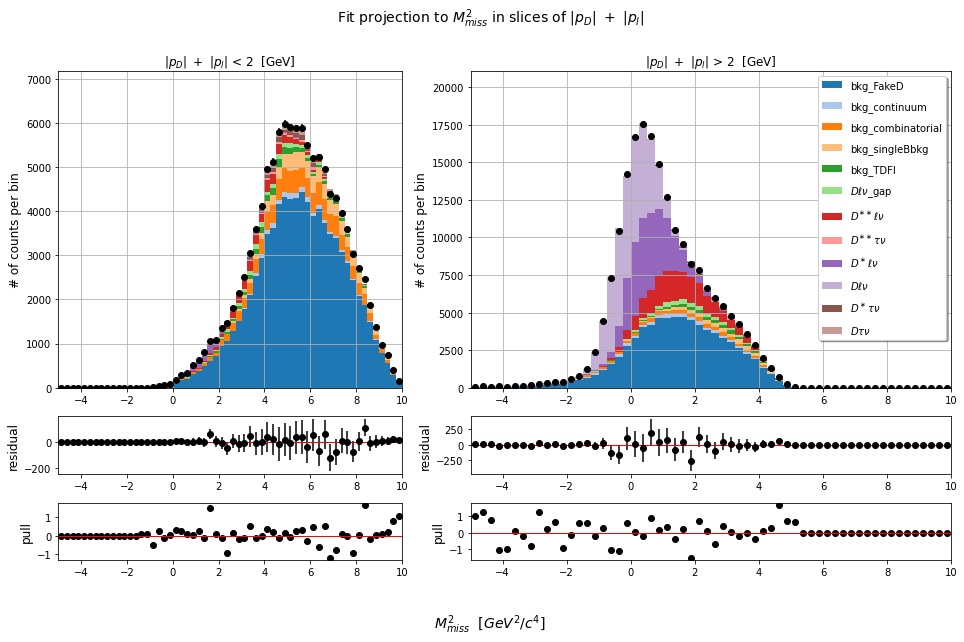

In [99]:
fig = util.fit_project_cabinetry(fit_result=res, templates_2d=temp_2d,
                      staterror_2d=stat_2d,data_2d=data_2d, 
                      edges_list=[MM2_bins, p_D_l_bins], 
                      direction='mm2', slice_thresholds=[2,2])

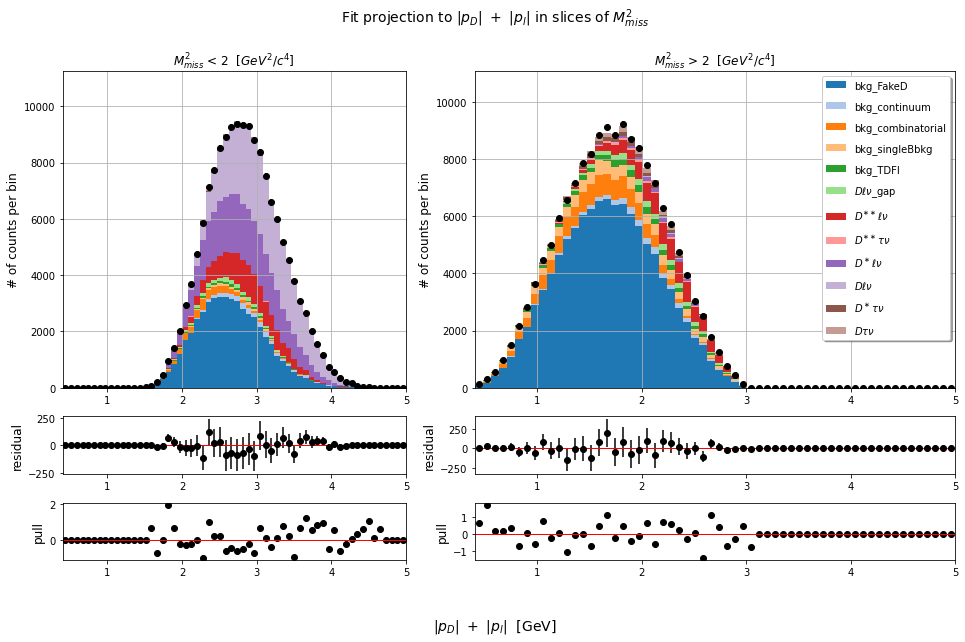

In [100]:
fig = util.fit_project_cabinetry(fit_result=res, templates_2d=temp_2d,
                      staterror_2d=stat_2d,data_2d=data_2d, 
                      edges_list=[MM2_bins, p_D_l_bins], 
                      direction='p_D_l', slice_thresholds=[2,2])

In [ ]:
# store_full=True

# # prepare containers for fit results
# fit_results = {
#     'best_twice_nll': [],
#     'pval': [],
#     'best_fit': []
# }
# if store_full:
# #             fit_results['main_data'] = []
# #             fit_results['aux_data'] = []
#     fit_results['uncertainty'] = []
#     fit_results['minos_uncertainty_up'] = []
#     fit_results['minos_uncertainty_down'] = []
#     minos_parameters = model.config.par_names[:8]

# failed_fits = 0
# attempted_fits = 0
# successful_fits = 0

# # fit toys
# with tqdm(total=len(toys), desc='Fitting toys') as pbar:
#     while attempted_fits < len(toys):
#         data = toys[attempted_fits]

#         try:
#             if store_full: # minuit and minos
#                 try:
#                     pyhf.set_backend('jax', 'scipy')
#                     init_pars = pyhf.infer.mle.fit(data=data, pdf=model,fixed_params=fix_par).tolist()

#                 except:
#                     init_pars = toy_pars


#                 pyhf.set_backend('jax', 'minuit')
#                 res = cabinetry.fit.fit(
#                     model,
#                     data=data,
#                     init_pars=init_pars,
#                     fix_pars = fix_par,
#                     # par_bounds=par_bounds,
#                     goodness_of_fit=True,
#                     minos=minos_parameters,
#                 )

#                 # save fit results
#                 fit_results['best_twice_nll'].append(res.best_twice_nll)
#                 fit_results['pval'].append(res.goodness_of_fit)
#                 fit_results['best_fit'].append(res.bestfit[:8].tolist())

#                 main_data, aux_data = model.fullpdf_tv.split(pyhf.tensorlib.astensor(data))
# #                         fit_results['main_data'].append(main_data.tolist())
# #                         fit_results['aux_data'].append(aux_data.tolist())
#                 fit_results['uncertainty'].append(res.uncertainty[:8].tolist())

#                 fit_results['minos_uncertainty_up'].append(
#                     [abs(res.minos_uncertainty[x][1]) for x in res.labels[:8]])
#                 fit_results['minos_uncertainty_down'].append(
#                     [abs(res.minos_uncertainty[x][0]) for x in res.labels[:8]])

#             else: # scipy only
#                 pyhf.set_backend('jax', 'scipy')
#                 bestfit_pars, twice_nll = pyhf.infer.mle.fit(data=data, pdf=model, 
#                                                              return_fitted_val=True,
#                                                              fixed_params=fix_par)

#                 # save fit results
#                 fit_results['best_twice_nll'].append(twice_nll.tolist())
#                 fit_results['best_fit'].append(bestfit_pars[:8].tolist())

#             successful_fits += 1
#             pbar.update(1)

#         except:
#             failed_fits += 1
#         attempted_fits += 1
#     pbar.close()

# for key in fit_results.keys():
#     # convert to json safe lists (these are much quicker to load then the yaml files later)
#     fit_results[key] = np.array(fit_results[key]).tolist()

# out_dict = {
#     'poi': model.config.par_names[:8],
#     'toy_pars': toy_pars[:8],
#     'results': fit_results,
#     'failed_fits': failed_fits,
#     'atempted_fits': attempted_fits
#                          }

In [19]:
out_dict

{'poi': ['$D\\ell\\nu$_norm',
  '$D\\tau\\nu$_norm',
  '$D^\\ast\\ell\\nu$_norm',
  '$D^\\ast\\tau\\nu$_norm',
  '$D^{\\ast\\ast}\\tau\\nu$_norm',
  'bkg_fakeD_norm',
  'gap_non_$D^{\\ast\\ast}\\ell\\nu$_norm',
  'res_$D^{\\ast\\ast}\\ell\\nu$_norm'],
 'toy_pars': [0.1310227205910763,
  0.06125947561513536,
  0.01778496954787699,
  0.013140250750420529,
  0.16452134544805178,
  0.18342355968276713,
  0.12526079739576418,
  0.1486043465869597],
 'results': {'best_twice_nll': [],
  'pval': [],
  'best_fit': [],
  'uncertainty': [],
  'minos_uncertainty_up': [],
  'minos_uncertainty_down': []},
 'failed_fits': 5,
 'atempted_fits': 5}

DEBUG - cabinetry.model_utils - total stdev is [[1, 2.24, 1.41, 2.24, 1.73, 1.41, 2.65, ..., 5.2, 1, 2, 3.87, 1, 1, 1], ...]
DEBUG - cabinetry.model_utils - total stdev per channel is [300, 300]
INFO - cabinetry.visualize.utils - saving figure as figures/e_channel_prefit.pdf
INFO - cabinetry.visualize.utils - saving figure as figures/mu_channel_prefit.pdf


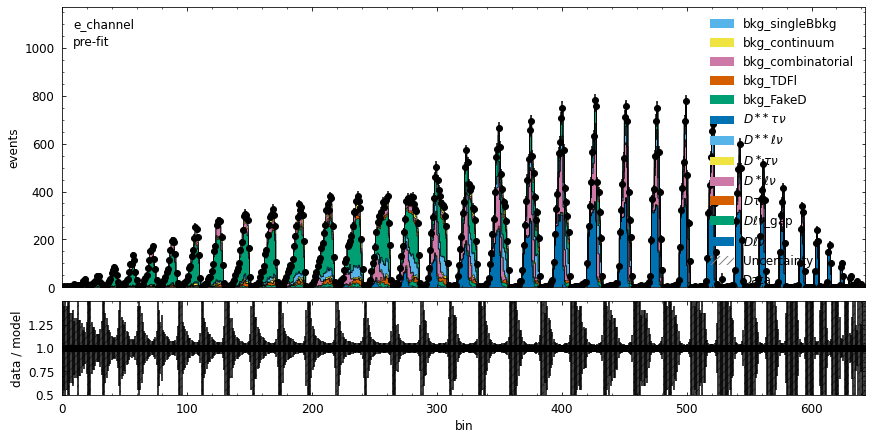

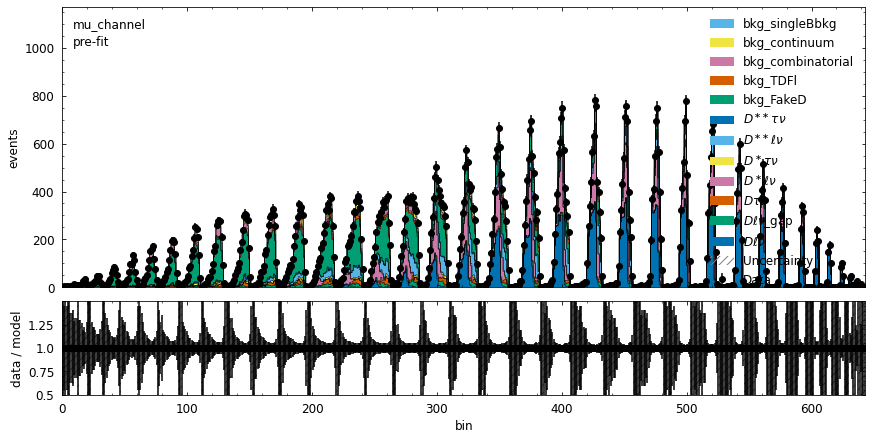

In [21]:
model_pred_prefit = cabinetry.model_utils.prediction(model)
#plt.figure(figsize=(16,6))
dms = cabinetry.visualize.data_mc(model_pred_prefit, data, log_scale=False)
for i in dms:
    i['figure'].set_figwidth(12)

# 3. MLE

In [ ]:
%%time
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])

In [22]:
%%time
## Asimov test with 333/fb
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model, data=data,
                                fix_pars=[False,False,False,False,False,False])#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit


W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4764                       │            Nfcn = 849541             │
│ EDM = 2.32e-08 (Goal: 0.0002)    │          time = 2282.3 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 4763.821745 at

INFO - cabinetry.fit - staterror_e_channel[89]    =  1.0000 +/- 0.0519
INFO - cabinetry.fit - staterror_e_channel[90]    =  1.0000 +/- 0.0603
INFO - cabinetry.fit - staterror_e_channel[91]    =  1.0000 +/- 0.0926
INFO - cabinetry.fit - staterror_e_channel[92]    =  1.0000 +/- 0.1669
INFO - cabinetry.fit - staterror_e_channel[93]    =  1.0000 +/- 0.4979
INFO - cabinetry.fit - staterror_e_channel[94]    =  1.0000 +/- 0.4090
INFO - cabinetry.fit - staterror_e_channel[95]    =  1.0000 +/- 0.4075
INFO - cabinetry.fit - staterror_e_channel[96]    =  1.0000 +/- 0.1967
INFO - cabinetry.fit - staterror_e_channel[97]    =  1.0000 +/- 0.1669
INFO - cabinetry.fit - staterror_e_channel[98]    =  1.0000 +/- 0.1479
INFO - cabinetry.fit - staterror_e_channel[99]    =  1.0000 +/- 0.1296
INFO - cabinetry.fit - staterror_e_channel[100]   =  1.0000 +/- 0.1024
INFO - cabinetry.fit - staterror_e_channel[101]   =  1.0000 +/- 0.0789
INFO - cabinetry.fit - staterror_e_channel[102]   =  1.0000 +/- 0.0752
INFO -

INFO - cabinetry.fit - staterror_e_channel[205]   =  1.0000 +/- 0.0674
INFO - cabinetry.fit - staterror_e_channel[206]   =  1.0000 +/- 0.0637
INFO - cabinetry.fit - staterror_e_channel[207]   =  1.0000 +/- 0.0552
INFO - cabinetry.fit - staterror_e_channel[208]   =  1.0000 +/- 0.0522
INFO - cabinetry.fit - staterror_e_channel[209]   =  1.0000 +/- 0.0474
INFO - cabinetry.fit - staterror_e_channel[210]   =  1.0000 +/- 0.0441
INFO - cabinetry.fit - staterror_e_channel[211]   =  1.0000 +/- 0.0397
INFO - cabinetry.fit - staterror_e_channel[212]   =  1.0000 +/- 0.0382
INFO - cabinetry.fit - staterror_e_channel[213]   =  1.0000 +/- 0.0398
INFO - cabinetry.fit - staterror_e_channel[214]   =  1.0000 +/- 0.0368
INFO - cabinetry.fit - staterror_e_channel[215]   =  1.0000 +/- 0.0370
INFO - cabinetry.fit - staterror_e_channel[216]   =  1.0000 +/- 0.0446
INFO - cabinetry.fit - staterror_e_channel[217]   =  1.0000 +/- 0.0638
INFO - cabinetry.fit - staterror_e_channel[218]   =  1.0000 +/- 0.1548
INFO -

INFO - cabinetry.fit - staterror_e_channel[321]   =  1.0000 +/- 0.0375
INFO - cabinetry.fit - staterror_e_channel[322]   =  1.0000 +/- 0.0317
INFO - cabinetry.fit - staterror_e_channel[323]   =  1.0000 +/- 0.0297
INFO - cabinetry.fit - staterror_e_channel[324]   =  1.0000 +/- 0.0310
INFO - cabinetry.fit - staterror_e_channel[325]   =  1.0000 +/- 0.0342
INFO - cabinetry.fit - staterror_e_channel[326]   =  1.0000 +/- 0.0353
INFO - cabinetry.fit - staterror_e_channel[327]   =  1.0000 +/- 0.0349
INFO - cabinetry.fit - staterror_e_channel[328]   =  1.0000 +/- 0.0392
INFO - cabinetry.fit - staterror_e_channel[329]   =  1.0000 +/- 0.0396
INFO - cabinetry.fit - staterror_e_channel[330]   =  1.0000 +/- 0.0426
INFO - cabinetry.fit - staterror_e_channel[331]   =  1.0000 +/- 0.0512
INFO - cabinetry.fit - staterror_e_channel[332]   =  1.0000 +/- 0.0725
INFO - cabinetry.fit - staterror_e_channel[333]   =  1.0000 +/- 0.3530
INFO - cabinetry.fit - staterror_e_channel[334]   =  1.0000 +/- 0.7007
INFO -

INFO - cabinetry.fit - staterror_e_channel[437]   =  1.0000 +/- 0.3539
INFO - cabinetry.fit - staterror_e_channel[438]   =  1.0000 +/- 0.2136
INFO - cabinetry.fit - staterror_e_channel[439]   =  1.0000 +/- 0.2884
INFO - cabinetry.fit - staterror_e_channel[440]   =  1.0000 +/- 0.2504
INFO - cabinetry.fit - staterror_e_channel[441]   =  1.0000 +/- 0.2239
INFO - cabinetry.fit - staterror_e_channel[442]   =  1.0000 +/- 0.2235
INFO - cabinetry.fit - staterror_e_channel[443]   =  1.0000 +/- 0.1581
INFO - cabinetry.fit - staterror_e_channel[444]   =  1.0000 +/- 0.1624
INFO - cabinetry.fit - staterror_e_channel[445]   =  1.0000 +/- 0.0760
INFO - cabinetry.fit - staterror_e_channel[446]   =  1.0000 +/- 0.0467
INFO - cabinetry.fit - staterror_e_channel[447]   =  1.0000 +/- 0.0397
INFO - cabinetry.fit - staterror_e_channel[448]   =  1.0000 +/- 0.0342
INFO - cabinetry.fit - staterror_e_channel[449]   =  1.0000 +/- 0.0305
INFO - cabinetry.fit - staterror_e_channel[450]   =  1.0000 +/- 0.0266
INFO -

INFO - cabinetry.fit - staterror_e_channel[553]   =  1.0000 +/- 0.4074
INFO - cabinetry.fit - staterror_e_channel[554]   =  1.0000 +/- 0.5004
INFO - cabinetry.fit - staterror_e_channel[555]   =  1.0000 +/- 0.2235
INFO - cabinetry.fit - staterror_e_channel[556]   =  1.0000 +/- 0.1962
INFO - cabinetry.fit - staterror_e_channel[557]   =  1.0000 +/- 0.1215
INFO - cabinetry.fit - staterror_e_channel[558]   =  1.0000 +/- 0.0486
INFO - cabinetry.fit - staterror_e_channel[559]   =  1.0000 +/- 0.0371
INFO - cabinetry.fit - staterror_e_channel[560]   =  1.0000 +/- 0.0353
INFO - cabinetry.fit - staterror_e_channel[561]   =  1.0000 +/- 0.0313
INFO - cabinetry.fit - staterror_e_channel[562]   =  1.0000 +/- 0.0372
INFO - cabinetry.fit - staterror_e_channel[563]   =  1.0000 +/- 0.0868
INFO - cabinetry.fit - staterror_e_channel[564]   =  1.0000 +/- 0.7091
INFO - cabinetry.fit - staterror_e_channel[565]   =  1.0000 +/- 0.4979
INFO - cabinetry.fit - staterror_e_channel[566]   =  1.0000 +/- 0.7025
INFO -

INFO - cabinetry.fit - staterror_mu_channel[26]   =  1.0000 +/- 0.1401
INFO - cabinetry.fit - staterror_mu_channel[27]   =  1.0000 +/- 0.1038
INFO - cabinetry.fit - staterror_mu_channel[28]   =  1.0000 +/- 0.1036
INFO - cabinetry.fit - staterror_mu_channel[29]   =  1.0000 +/- 0.1038
INFO - cabinetry.fit - staterror_mu_channel[30]   =  1.0000 +/- 0.1449
INFO - cabinetry.fit - staterror_mu_channel[31]   =  1.0000 +/- 0.2045
INFO - cabinetry.fit - staterror_mu_channel[32]   =  1.0000 +/- 0.4979
INFO - cabinetry.fit - staterror_mu_channel[33]   =  1.0000 +/- 0.7027
INFO - cabinetry.fit - staterror_mu_channel[34]   =  1.0000 +/- 0.2674
INFO - cabinetry.fit - staterror_mu_channel[35]   =  1.0000 +/- 0.2237
INFO - cabinetry.fit - staterror_mu_channel[36]   =  1.0000 +/- 0.1776
INFO - cabinetry.fit - staterror_mu_channel[37]   =  1.0000 +/- 0.1341
INFO - cabinetry.fit - staterror_mu_channel[38]   =  1.0000 +/- 0.1187
INFO - cabinetry.fit - staterror_mu_channel[39]   =  1.0000 +/- 0.0931
INFO -

INFO - cabinetry.fit - staterror_mu_channel[142]  =  1.0000 +/- 0.0571
INFO - cabinetry.fit - staterror_mu_channel[143]  =  1.0000 +/- 0.0517
INFO - cabinetry.fit - staterror_mu_channel[144]  =  1.0000 +/- 0.0460
INFO - cabinetry.fit - staterror_mu_channel[145]  =  1.0000 +/- 0.0415
INFO - cabinetry.fit - staterror_mu_channel[146]  =  1.0000 +/- 0.0410
INFO - cabinetry.fit - staterror_mu_channel[147]  =  1.0000 +/- 0.0411
INFO - cabinetry.fit - staterror_mu_channel[148]  =  1.0000 +/- 0.0426
INFO - cabinetry.fit - staterror_mu_channel[149]  =  1.0000 +/- 0.0554
INFO - cabinetry.fit - staterror_mu_channel[150]  =  1.0000 +/- 0.1058
INFO - cabinetry.fit - staterror_mu_channel[151]  =  1.0000 +/- 0.3160
INFO - cabinetry.fit - staterror_mu_channel[152]  =  1.0000 +/- 0.4071
INFO - cabinetry.fit - staterror_mu_channel[153]  =  1.0000 +/- 0.4985
INFO - cabinetry.fit - staterror_mu_channel[154]  =  1.0000 +/- 0.2357
INFO - cabinetry.fit - staterror_mu_channel[155]  =  1.0000 +/- 0.2357
INFO -

INFO - cabinetry.fit - staterror_mu_channel[258]  =  1.0000 +/- 0.0374
INFO - cabinetry.fit - staterror_mu_channel[259]  =  1.0000 +/- 0.0377
INFO - cabinetry.fit - staterror_mu_channel[260]  =  1.0000 +/- 0.0367
INFO - cabinetry.fit - staterror_mu_channel[261]  =  1.0000 +/- 0.0438
INFO - cabinetry.fit - staterror_mu_channel[262]  =  1.0000 +/- 0.0541
INFO - cabinetry.fit - staterror_mu_channel[263]  =  1.0000 +/- 0.1315
INFO - cabinetry.fit - staterror_mu_channel[264]  =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[265]  =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[266]  =  1.0000 +/- 0.3529
INFO - cabinetry.fit - staterror_mu_channel[267]  =  1.0000 +/- 0.1717
INFO - cabinetry.fit - staterror_mu_channel[268]  =  1.0000 +/- 0.1827
INFO - cabinetry.fit - staterror_mu_channel[269]  =  1.0000 +/- 0.1067
INFO - cabinetry.fit - staterror_mu_channel[270]  =  1.0000 +/- 0.0792
INFO - cabinetry.fit - staterror_mu_channel[271]  =  1.0000 +/- 0.0625
INFO -

INFO - cabinetry.fit - staterror_mu_channel[374]  =  1.0000 +/- 0.0277
INFO - cabinetry.fit - staterror_mu_channel[375]  =  1.0000 +/- 0.0269
INFO - cabinetry.fit - staterror_mu_channel[376]  =  1.0000 +/- 0.0304
INFO - cabinetry.fit - staterror_mu_channel[377]  =  1.0000 +/- 0.0326
INFO - cabinetry.fit - staterror_mu_channel[378]  =  1.0000 +/- 0.0368
INFO - cabinetry.fit - staterror_mu_channel[379]  =  1.0000 +/- 0.0425
INFO - cabinetry.fit - staterror_mu_channel[380]  =  1.0000 +/- 0.0403
INFO - cabinetry.fit - staterror_mu_channel[381]  =  1.0000 +/- 0.0500
INFO - cabinetry.fit - staterror_mu_channel[382]  =  1.0000 +/- 0.1019
INFO - cabinetry.fit - staterror_mu_channel[383]  =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[384]  =  1.0000 +/- 0.7027
INFO - cabinetry.fit - staterror_mu_channel[385]  =  1.0000 +/- 0.4071
INFO - cabinetry.fit - staterror_mu_channel[386]  =  1.0000 +/- 0.2675
INFO - cabinetry.fit - staterror_mu_channel[387]  =  1.0000 +/- 0.4992
INFO -

INFO - cabinetry.fit - staterror_mu_channel[490]  =  1.0000 +/- 0.2364
INFO - cabinetry.fit - staterror_mu_channel[491]  =  1.0000 +/- 0.2499
INFO - cabinetry.fit - staterror_mu_channel[492]  =  1.0000 +/- 0.1838
INFO - cabinetry.fit - staterror_mu_channel[493]  =  1.0000 +/- 0.1272
INFO - cabinetry.fit - staterror_mu_channel[494]  =  1.0000 +/- 0.0546
INFO - cabinetry.fit - staterror_mu_channel[495]  =  1.0000 +/- 0.0396
INFO - cabinetry.fit - staterror_mu_channel[496]  =  1.0000 +/- 0.0348
INFO - cabinetry.fit - staterror_mu_channel[497]  =  1.0000 +/- 0.0310
INFO - cabinetry.fit - staterror_mu_channel[498]  =  1.0000 +/- 0.0270
INFO - cabinetry.fit - staterror_mu_channel[499]  =  1.0000 +/- 0.0255
INFO - cabinetry.fit - staterror_mu_channel[500]  =  1.0000 +/- 0.0330
INFO - cabinetry.fit - staterror_mu_channel[501]  =  1.0000 +/- 0.0435
INFO - cabinetry.fit - staterror_mu_channel[502]  =  1.0000 +/- 0.0684
INFO - cabinetry.fit - staterror_mu_channel[503]  =  1.0000 +/- 0.7007
INFO -

INFO - cabinetry.fit - staterror_mu_channel[606]  =  1.0000 +/- 0.2884
INFO - cabinetry.fit - staterror_mu_channel[607]  =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[608]  =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[609]  =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[610]  =  1.0000 +/- 0.3528
INFO - cabinetry.fit - staterror_mu_channel[611]  =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[612]  =  1.0000 +/- 0.1508
INFO - cabinetry.fit - staterror_mu_channel[613]  =  1.0000 +/- 0.0582
INFO - cabinetry.fit - staterror_mu_channel[614]  =  1.0000 +/- 0.0531
INFO - cabinetry.fit - staterror_mu_channel[615]  =  1.0000 +/- 0.0708
INFO - cabinetry.fit - staterror_mu_channel[616]  =  1.0000 +/- 0.7091
INFO - cabinetry.fit - staterror_mu_channel[617]  =  1.0000 +/- 0.7025
INFO - cabinetry.fit - staterror_mu_channel[618]  =  1.0000 +/- 0.4074
INFO - cabinetry.fit - staterror_mu_channel[619]  =  1.0000 +/- 0.7091
INFO -

CPU times: user 1h 15min 35s, sys: 3min 56s, total: 1h 19min 31s
Wall time: 43min 39s


In [12]:
%%time
## Asimov test with 1/ab
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model, data=data,
                                fix_pars=[False,False,False,False,False,False])#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit


W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5259                       │            Nfcn = 1035843            │
│ EDM = 2.27e-08 (Goal: 0.0002)    │          time = 2818.7 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 5259.295231 at

INFO - cabinetry.fit - staterror_e_channel[89]    =  1.0000 +/- 0.0531
INFO - cabinetry.fit - staterror_e_channel[90]    =  1.0000 +/- 0.0465
INFO - cabinetry.fit - staterror_e_channel[91]    =  1.0000 +/- 0.0384
INFO - cabinetry.fit - staterror_e_channel[92]    =  1.0000 +/- 0.0338
INFO - cabinetry.fit - staterror_e_channel[93]    =  1.0000 +/- 0.0304
INFO - cabinetry.fit - staterror_e_channel[94]    =  1.0000 +/- 0.0278
INFO - cabinetry.fit - staterror_e_channel[95]    =  1.0000 +/- 0.0294
INFO - cabinetry.fit - staterror_e_channel[96]    =  1.0000 +/- 0.0357
INFO - cabinetry.fit - staterror_e_channel[97]    =  1.0000 +/- 0.0508
INFO - cabinetry.fit - staterror_e_channel[98]    =  1.0000 +/- 0.0966
INFO - cabinetry.fit - staterror_e_channel[99]    =  1.0000 +/- 0.4071
INFO - cabinetry.fit - staterror_e_channel[100]   =  1.0000 +/- 0.4071
INFO - cabinetry.fit - staterror_e_channel[101]   =  1.0000 +/- 0.2138
INFO - cabinetry.fit - staterror_e_channel[102]   =  1.0000 +/- 0.1894
INFO -

INFO - cabinetry.fit - staterror_e_channel[205]   =  1.0000 +/- 0.2671
INFO - cabinetry.fit - staterror_e_channel[206]   =  1.0000 +/- 0.7018
INFO - cabinetry.fit - staterror_e_channel[207]   =  1.0000 +/- 0.3528
INFO - cabinetry.fit - staterror_e_channel[208]   =  1.0000 +/- 0.2497
INFO - cabinetry.fit - staterror_e_channel[209]   =  1.0000 +/- 0.1361
INFO - cabinetry.fit - staterror_e_channel[210]   =  1.0000 +/- 0.1133
INFO - cabinetry.fit - staterror_e_channel[211]   =  1.0000 +/- 0.0742
INFO - cabinetry.fit - staterror_e_channel[212]   =  1.0000 +/- 0.0610
INFO - cabinetry.fit - staterror_e_channel[213]   =  1.0000 +/- 0.0529
INFO - cabinetry.fit - staterror_e_channel[214]   =  1.0000 +/- 0.0440
INFO - cabinetry.fit - staterror_e_channel[215]   =  1.0000 +/- 0.0397
INFO - cabinetry.fit - staterror_e_channel[216]   =  1.0000 +/- 0.0364
INFO - cabinetry.fit - staterror_e_channel[217]   =  1.0000 +/- 0.0331
INFO - cabinetry.fit - staterror_e_channel[218]   =  1.0000 +/- 0.0298
INFO -

INFO - cabinetry.fit - staterror_e_channel[321]   =  1.0000 +/- 0.0219
INFO - cabinetry.fit - staterror_e_channel[322]   =  1.0000 +/- 0.0226
INFO - cabinetry.fit - staterror_e_channel[323]   =  1.0000 +/- 0.0234
INFO - cabinetry.fit - staterror_e_channel[324]   =  1.0000 +/- 0.0259
INFO - cabinetry.fit - staterror_e_channel[325]   =  1.0000 +/- 0.0412
INFO - cabinetry.fit - staterror_e_channel[326]   =  1.0000 +/- 0.1339
INFO - cabinetry.fit - staterror_e_channel[327]   =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_e_channel[328]   =  1.0000 +/- 0.3528
INFO - cabinetry.fit - staterror_e_channel[329]   =  1.0000 +/- 0.3165
INFO - cabinetry.fit - staterror_e_channel[330]   =  1.0000 +/- 0.4978
INFO - cabinetry.fit - staterror_e_channel[331]   =  1.0000 +/- 0.2355
INFO - cabinetry.fit - staterror_e_channel[332]   =  1.0000 +/- 0.1510
INFO - cabinetry.fit - staterror_e_channel[333]   =  1.0000 +/- 0.1509
INFO - cabinetry.fit - staterror_e_channel[334]   =  1.0000 +/- 0.0966
INFO -

INFO - cabinetry.fit - staterror_e_channel[437]   =  1.0000 +/- 0.1623
INFO - cabinetry.fit - staterror_e_channel[438]   =  1.0000 +/- 0.1627
INFO - cabinetry.fit - staterror_e_channel[439]   =  1.0000 +/- 0.2235
INFO - cabinetry.fit - staterror_e_channel[440]   =  1.0000 +/- 0.1510
INFO - cabinetry.fit - staterror_e_channel[441]   =  1.0000 +/- 0.1338
INFO - cabinetry.fit - staterror_e_channel[442]   =  1.0000 +/- 0.1082
INFO - cabinetry.fit - staterror_e_channel[443]   =  1.0000 +/- 0.0916
INFO - cabinetry.fit - staterror_e_channel[444]   =  1.0000 +/- 0.0818
INFO - cabinetry.fit - staterror_e_channel[445]   =  1.0000 +/- 0.0441
INFO - cabinetry.fit - staterror_e_channel[446]   =  1.0000 +/- 0.0267
INFO - cabinetry.fit - staterror_e_channel[447]   =  1.0000 +/- 0.0225
INFO - cabinetry.fit - staterror_e_channel[448]   =  1.0000 +/- 0.0198
INFO - cabinetry.fit - staterror_e_channel[449]   =  1.0000 +/- 0.0175
INFO - cabinetry.fit - staterror_e_channel[450]   =  1.0000 +/- 0.0162
INFO -

INFO - cabinetry.fit - staterror_e_channel[553]   =  1.0000 +/- 0.4980
INFO - cabinetry.fit - staterror_e_channel[554]   =  1.0000 +/- 0.4072
INFO - cabinetry.fit - staterror_e_channel[555]   =  1.0000 +/- 0.3534
INFO - cabinetry.fit - staterror_e_channel[556]   =  1.0000 +/- 0.2893
INFO - cabinetry.fit - staterror_e_channel[557]   =  1.0000 +/- 0.2893
INFO - cabinetry.fit - staterror_e_channel[558]   =  1.0000 +/- 0.3158
INFO - cabinetry.fit - staterror_e_channel[559]   =  1.0000 +/- 0.2240
INFO - cabinetry.fit - staterror_e_channel[560]   =  1.0000 +/- 0.2136
INFO - cabinetry.fit - staterror_e_channel[561]   =  1.0000 +/- 0.2673
INFO - cabinetry.fit - staterror_e_channel[562]   =  1.0000 +/- 0.2140
INFO - cabinetry.fit - staterror_e_channel[563]   =  1.0000 +/- 0.1365
INFO - cabinetry.fit - staterror_e_channel[564]   =  1.0000 +/- 0.1509
INFO - cabinetry.fit - staterror_e_channel[565]   =  1.0000 +/- 0.1081
INFO - cabinetry.fit - staterror_e_channel[566]   =  1.0000 +/- 0.0473
INFO -

INFO - cabinetry.fit - staterror_e_channel[669]   =  1.0000 +/- 0.3529
INFO - cabinetry.fit - staterror_e_channel[670]   =  1.0000 +/- 0.4112
INFO - cabinetry.fit - staterror_e_channel[671]   =  1.0000 +/- 0.3532
INFO - cabinetry.fit - staterror_e_channel[672]   =  1.0000 +/- 0.3160
INFO - cabinetry.fit - staterror_e_channel[673]   =  1.0000 +/- 0.1443
INFO - cabinetry.fit - staterror_e_channel[674]   =  1.0000 +/- 0.0448
INFO - cabinetry.fit - staterror_e_channel[675]   =  1.0000 +/- 0.0400
INFO - cabinetry.fit - staterror_e_channel[676]   =  1.0000 +/- 0.0623
INFO - cabinetry.fit - staterror_e_channel[677]   =  1.0000 +/- 0.7006
INFO - cabinetry.fit - staterror_e_channel[678]   =  1.0000 +/- 0.4990
INFO - cabinetry.fit - staterror_e_channel[679]   =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_e_channel[680]   =  1.0000 +/- 0.7006
INFO - cabinetry.fit - staterror_e_channel[681]   =  1.0000 +/- 0.7006
INFO - cabinetry.fit - staterror_e_channel[682]   =  1.0000 +/- 0.3537
INFO -

INFO - cabinetry.fit - staterror_mu_channel[74]   =  1.0000 +/- 0.0421
INFO - cabinetry.fit - staterror_mu_channel[75]   =  1.0000 +/- 0.0353
INFO - cabinetry.fit - staterror_mu_channel[76]   =  1.0000 +/- 0.0322
INFO - cabinetry.fit - staterror_mu_channel[77]   =  1.0000 +/- 0.0327
INFO - cabinetry.fit - staterror_mu_channel[78]   =  1.0000 +/- 0.0364
INFO - cabinetry.fit - staterror_mu_channel[79]   =  1.0000 +/- 0.0520
INFO - cabinetry.fit - staterror_mu_channel[80]   =  1.0000 +/- 0.0883
INFO - cabinetry.fit - staterror_mu_channel[81]   =  1.0000 +/- 0.2236
INFO - cabinetry.fit - staterror_mu_channel[82]   =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[83]   =  1.0000 +/- 0.1715
INFO - cabinetry.fit - staterror_mu_channel[84]   =  1.0000 +/- 0.1444
INFO - cabinetry.fit - staterror_mu_channel[85]   =  1.0000 +/- 0.1277
INFO - cabinetry.fit - staterror_mu_channel[86]   =  1.0000 +/- 0.0872
INFO - cabinetry.fit - staterror_mu_channel[87]   =  1.0000 +/- 0.0720
INFO -

INFO - cabinetry.fit - staterror_mu_channel[190]  =  1.0000 +/- 0.0524
INFO - cabinetry.fit - staterror_mu_channel[191]  =  1.0000 +/- 0.0482
INFO - cabinetry.fit - staterror_mu_channel[192]  =  1.0000 +/- 0.0448
INFO - cabinetry.fit - staterror_mu_channel[193]  =  1.0000 +/- 0.0424
INFO - cabinetry.fit - staterror_mu_channel[194]  =  1.0000 +/- 0.0356
INFO - cabinetry.fit - staterror_mu_channel[195]  =  1.0000 +/- 0.0315
INFO - cabinetry.fit - staterror_mu_channel[196]  =  1.0000 +/- 0.0272
INFO - cabinetry.fit - staterror_mu_channel[197]  =  1.0000 +/- 0.0251
INFO - cabinetry.fit - staterror_mu_channel[198]  =  1.0000 +/- 0.0237
INFO - cabinetry.fit - staterror_mu_channel[199]  =  1.0000 +/- 0.0224
INFO - cabinetry.fit - staterror_mu_channel[200]  =  1.0000 +/- 0.0224
INFO - cabinetry.fit - staterror_mu_channel[201]  =  1.0000 +/- 0.0224
INFO - cabinetry.fit - staterror_mu_channel[202]  =  1.0000 +/- 0.0236
INFO - cabinetry.fit - staterror_mu_channel[203]  =  1.0000 +/- 0.0300
INFO -

INFO - cabinetry.fit - staterror_mu_channel[306]  =  1.0000 +/- 0.1667
INFO - cabinetry.fit - staterror_mu_channel[307]  =  1.0000 +/- 0.1163
INFO - cabinetry.fit - staterror_mu_channel[308]  =  1.0000 +/- 0.0921
INFO - cabinetry.fit - staterror_mu_channel[309]  =  1.0000 +/- 0.0605
INFO - cabinetry.fit - staterror_mu_channel[310]  =  1.0000 +/- 0.0475
INFO - cabinetry.fit - staterror_mu_channel[311]  =  1.0000 +/- 0.0339
INFO - cabinetry.fit - staterror_mu_channel[312]  =  1.0000 +/- 0.0276
INFO - cabinetry.fit - staterror_mu_channel[313]  =  1.0000 +/- 0.0238
INFO - cabinetry.fit - staterror_mu_channel[314]  =  1.0000 +/- 0.0214
INFO - cabinetry.fit - staterror_mu_channel[315]  =  1.0000 +/- 0.0197
INFO - cabinetry.fit - staterror_mu_channel[316]  =  1.0000 +/- 0.0191
INFO - cabinetry.fit - staterror_mu_channel[317]  =  1.0000 +/- 0.0197
INFO - cabinetry.fit - staterror_mu_channel[318]  =  1.0000 +/- 0.0205
INFO - cabinetry.fit - staterror_mu_channel[319]  =  1.0000 +/- 0.0208
INFO -

INFO - cabinetry.fit - staterror_mu_channel[422]  =  1.0000 +/- 0.0179
INFO - cabinetry.fit - staterror_mu_channel[423]  =  1.0000 +/- 0.0164
INFO - cabinetry.fit - staterror_mu_channel[424]  =  1.0000 +/- 0.0153
INFO - cabinetry.fit - staterror_mu_channel[425]  =  1.0000 +/- 0.0150
INFO - cabinetry.fit - staterror_mu_channel[426]  =  1.0000 +/- 0.0173
INFO - cabinetry.fit - staterror_mu_channel[427]  =  1.0000 +/- 0.0202
INFO - cabinetry.fit - staterror_mu_channel[428]  =  1.0000 +/- 0.0220
INFO - cabinetry.fit - staterror_mu_channel[429]  =  1.0000 +/- 0.0240
INFO - cabinetry.fit - staterror_mu_channel[430]  =  1.0000 +/- 0.0288
INFO - cabinetry.fit - staterror_mu_channel[431]  =  1.0000 +/- 0.0615
INFO - cabinetry.fit - staterror_mu_channel[432]  =  1.0000 +/- 0.3529
INFO - cabinetry.fit - staterror_mu_channel[433]  =  1.0000 +/- 0.4996
INFO - cabinetry.fit - staterror_mu_channel[434]  =  1.0000 +/- 0.3160
INFO - cabinetry.fit - staterror_mu_channel[435]  =  1.0000 +/- 0.2498
INFO -

INFO - cabinetry.fit - staterror_mu_channel[538]  =  1.0000 +/- 0.1836
INFO - cabinetry.fit - staterror_mu_channel[539]  =  1.0000 +/- 0.1587
INFO - cabinetry.fit - staterror_mu_channel[540]  =  1.0000 +/- 0.1962
INFO - cabinetry.fit - staterror_mu_channel[541]  =  1.0000 +/- 0.1251
INFO - cabinetry.fit - staterror_mu_channel[542]  =  1.0000 +/- 0.1509
INFO - cabinetry.fit - staterror_mu_channel[543]  =  1.0000 +/- 0.0906
INFO - cabinetry.fit - staterror_mu_channel[544]  =  1.0000 +/- 0.0382
INFO - cabinetry.fit - staterror_mu_channel[545]  =  1.0000 +/- 0.0233
INFO - cabinetry.fit - staterror_mu_channel[546]  =  1.0000 +/- 0.0203
INFO - cabinetry.fit - staterror_mu_channel[547]  =  1.0000 +/- 0.0173
INFO - cabinetry.fit - staterror_mu_channel[548]  =  1.0000 +/- 0.0160
INFO - cabinetry.fit - staterror_mu_channel[549]  =  1.0000 +/- 0.0159
INFO - cabinetry.fit - staterror_mu_channel[550]  =  1.0000 +/- 0.0226
INFO - cabinetry.fit - staterror_mu_channel[551]  =  1.0000 +/- 0.0347
INFO -

INFO - cabinetry.fit - staterror_mu_channel[654]  =  1.0000 +/- 0.3532
INFO - cabinetry.fit - staterror_mu_channel[655]  =  1.0000 +/- 0.4072
INFO - cabinetry.fit - staterror_mu_channel[656]  =  1.0000 +/- 0.2669
INFO - cabinetry.fit - staterror_mu_channel[657]  =  1.0000 +/- 0.2883
INFO - cabinetry.fit - staterror_mu_channel[658]  =  1.0000 +/- 0.0781
INFO - cabinetry.fit - staterror_mu_channel[659]  =  1.0000 +/- 0.0348
INFO - cabinetry.fit - staterror_mu_channel[660]  =  1.0000 +/- 0.0335
INFO - cabinetry.fit - staterror_mu_channel[661]  =  1.0000 +/- 0.0419
INFO - cabinetry.fit - staterror_mu_channel[662]  =  1.0000 +/- 0.7015
INFO - cabinetry.fit - staterror_mu_channel[663]  =  1.0000 +/- 0.7015
INFO - cabinetry.fit - staterror_mu_channel[664]  =  1.0000 +/- 0.7060
INFO - cabinetry.fit - staterror_mu_channel[665]  =  1.0000 +/- 0.4985
INFO - cabinetry.fit - staterror_mu_channel[666]  =  1.0000 +/- 0.4990
INFO - cabinetry.fit - staterror_mu_channel[667]  =  1.0000 +/- 0.7015
INFO -

CPU times: user 1h 45min 6s, sys: 5min 20s, total: 1h 50min 26s
Wall time: 52min 51s


In [6]:
%%time
## Asimov test with 200/fb, binning=50,25
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model, data=data,
                                fix_pars=[False,False,False,False,False,False])#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit


W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1440                       │             Nfcn = 82603             │
│ EDM = 7.23e-10 (Goal: 0.0002)    │           time = 33.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 1440.329018 at

INFO - cabinetry.fit - staterror_0_channel[89]    =  1.0000 +/- 0.1122
INFO - cabinetry.fit - staterror_0_channel[90]    =  1.0000 +/- 0.0922
INFO - cabinetry.fit - staterror_0_channel[91]    =  1.0000 +/- 0.0785
INFO - cabinetry.fit - staterror_0_channel[92]    =  1.0000 +/- 0.0676
INFO - cabinetry.fit - staterror_0_channel[93]    =  1.0000 +/- 0.0591
INFO - cabinetry.fit - staterror_0_channel[94]    =  1.0000 +/- 0.0536
INFO - cabinetry.fit - staterror_0_channel[95]    =  1.0000 +/- 0.0470
INFO - cabinetry.fit - staterror_0_channel[96]    =  1.0000 +/- 0.0464
INFO - cabinetry.fit - staterror_0_channel[97]    =  1.0000 +/- 0.0387
INFO - cabinetry.fit - staterror_0_channel[98]    =  1.0000 +/- 0.0412
INFO - cabinetry.fit - staterror_0_channel[99]    =  1.0000 +/- 0.0435
INFO - cabinetry.fit - staterror_0_channel[100]   =  1.0000 +/- 0.0531
INFO - cabinetry.fit - staterror_0_channel[101]   =  1.0000 +/- 0.0699
INFO - cabinetry.fit - staterror_0_channel[102]   =  1.0000 +/- 0.1555
INFO -

INFO - cabinetry.fit - staterror_0_channel[205]   =  1.0000 +/- 0.0625
INFO - cabinetry.fit - staterror_0_channel[206]   =  1.0000 +/- 0.0492
INFO - cabinetry.fit - staterror_0_channel[207]   =  1.0000 +/- 0.0427
INFO - cabinetry.fit - staterror_0_channel[208]   =  1.0000 +/- 0.0374
INFO - cabinetry.fit - staterror_0_channel[209]   =  1.0000 +/- 0.0323
INFO - cabinetry.fit - staterror_0_channel[210]   =  1.0000 +/- 0.0300
INFO - cabinetry.fit - staterror_0_channel[211]   =  1.0000 +/- 0.0278
INFO - cabinetry.fit - staterror_0_channel[212]   =  1.0000 +/- 0.0291
INFO - cabinetry.fit - staterror_0_channel[213]   =  1.0000 +/- 0.0341
INFO - cabinetry.fit - staterror_0_channel[214]   =  1.0000 +/- 0.0357
INFO - cabinetry.fit - staterror_0_channel[215]   =  1.0000 +/- 0.0364
INFO - cabinetry.fit - staterror_0_channel[216]   =  1.0000 +/- 0.0398
INFO - cabinetry.fit - staterror_0_channel[217]   =  1.0000 +/- 0.0412
INFO - cabinetry.fit - staterror_0_channel[218]   =  1.0000 +/- 0.0502
INFO -

INFO - cabinetry.fit - staterror_0_channel[321]   =  1.0000 +/- 0.3184
INFO - cabinetry.fit - staterror_0_channel[322]   =  1.0000 +/- 0.4145
INFO - cabinetry.fit - staterror_0_channel[323]   =  1.0000 +/- 0.2677
INFO - cabinetry.fit - staterror_0_channel[324]   =  1.0000 +/- 0.2258
INFO - cabinetry.fit - staterror_0_channel[325]   =  1.0000 +/- 0.2057
INFO - cabinetry.fit - staterror_0_channel[326]   =  1.0000 +/- 0.0833
INFO - cabinetry.fit - staterror_0_channel[327]   =  1.0000 +/- 0.0446
INFO - cabinetry.fit - staterror_0_channel[328]   =  1.0000 +/- 0.0369
INFO - cabinetry.fit - staterror_0_channel[329]   =  1.0000 +/- 0.0327
INFO - cabinetry.fit - staterror_0_channel[330]   =  1.0000 +/- 0.0293
INFO - cabinetry.fit - staterror_0_channel[331]   =  1.0000 +/- 0.0319
INFO - cabinetry.fit - staterror_0_channel[332]   =  1.0000 +/- 0.0548
INFO - cabinetry.fit - staterror_0_channel[333]   =  1.0000 +/- 0.1345
INFO - cabinetry.fit - staterror_0_channel[334]   =  1.0000 +/- 0.7085
INFO -

CPU times: user 1min 1s, sys: 634 ms, total: 1min 1s
Wall time: 1min 17s


In [ ]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


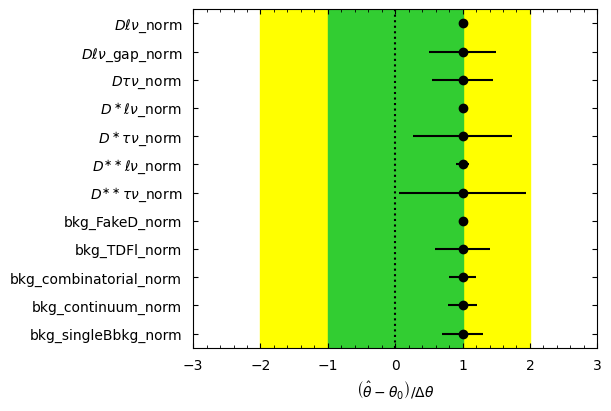

In [22]:
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


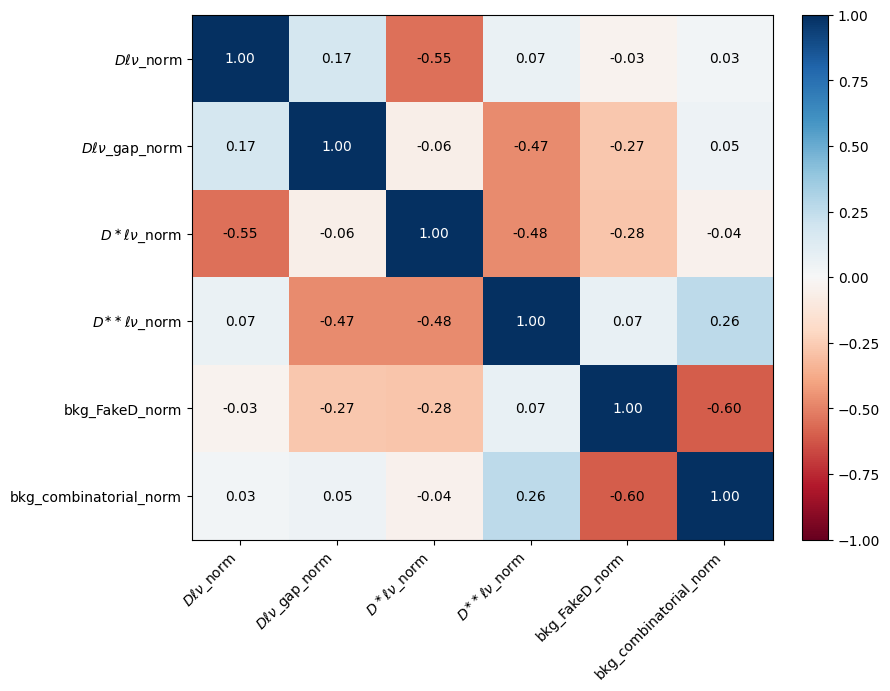

In [28]:
# 3/ab template with weight=0.12 and no staterror
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.35)

INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3955                       │              Nfcn = 73               │
│ EDM = 2.23e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 3955.304735 at

W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3960                       │        Nfcn = 101, Ngrad = 9         │
│ EDM = 0.000513 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 3960.403538 at

DEBUG - cabinetry.fit - -2 log(L) = 3957.894671 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.565
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3958                       │         Nfcn = 99, Ngrad = 8         │
│ EDM = 1.63e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3956.059152 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.778
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3956                       │        Nfcn = 101, Ngrad = 8         │
│ EDM = 1.25e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3955.321419 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.990
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3955                       │         Nfcn = 75, Ngrad = 2         │
│ EDM = 0.000493 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3955.679596 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 1.202
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3956                       │         Nfcn = 95, Ngrad = 8         │
│ EDM = 1.37e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3957.135240 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 1.414
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3957                       │         Nfcn = 98, Ngrad = 9         │
│ EDM = 6.46e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3959.692705 at best-fit point
INFO - cabinetry.visualize.utils - saving figure as figures/scan_$D\tau\nu$_norm.pdf


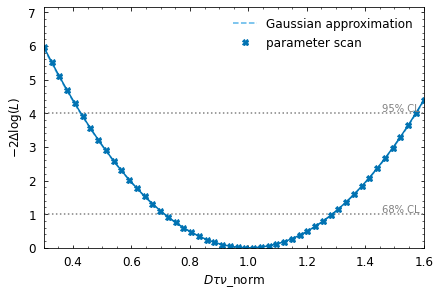

In [80]:
scan_0=cabinetry.fit.scan(model=model, data=data,par_name=r'$D\tau\nu$_norm',par_range=[0.3,1.6],n_steps=50)
cabinetry.visualize.scan(scan_0)

INFO - cabinetry.visualize.utils - saving figure as figures/electron_postfit.pdf


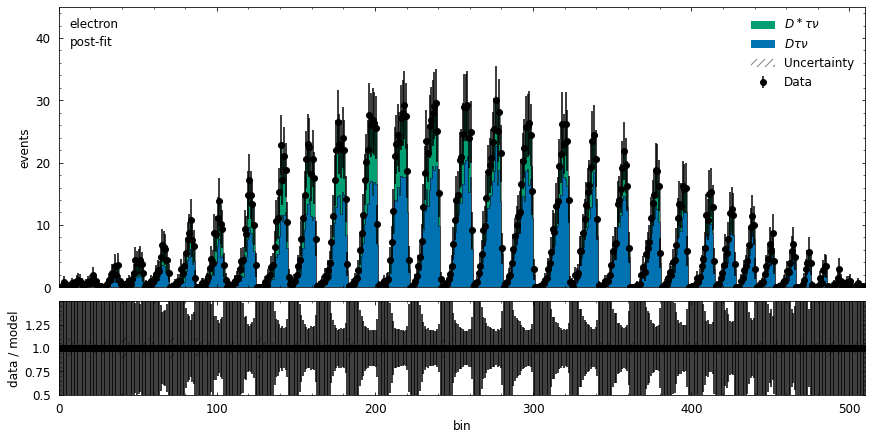

In [105]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, log_scale=False)
for i in _:
    i['figure'].set_figwidth(12)